# 导入包

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# 定义函数

In [2]:
def show2dfig(X, labels=None):
    if X.shape[1] != 2: print('dimension error!'); return
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=labels)
    plt.show()

# 定义类

In [3]:
class SlidingWindow():
    """
    Attributes:
        centroid: {ndarray(n_features,)}
        epsilon: {float} 滑动窗格大小，为半径的平方
        sigma: {float} 高斯核函数的参数
        label: {int} 该窗格的标记
        X: {ndarray(n_samples, n_features)}
        containIdx: {ndarray(n_contain,)} 窗格内包含点的索引
    """
    def __init__(self, centroid, epsilon, sigma, label, X):
        self.centroid = centroid
        self.epsilon = epsilon
        self.sigma = sigma
        self.label = label
        self.containIdx = self.updateContain(X)
    def k(self, z):
        """ 高斯核函数
        Args:
            z: {ndarray(n_features,)}
        Notes:
            - \kappa(z) = \frac{1}{\sqrt{2\pi}} \exp \left( - \frac{||z||^2}{2\sigma^2} \right)
        """
        norm = np.linalg.norm(z)
        return np.exp(- 0.5 * (norm / self.sigma)**2) / np.sqrt(2*np.pi)
    def step(self, X):
        """ 更新滑动窗格的中心点和所包含点
        Returns: {float}
        """
        dshift = self.shift(X)
        self.containIdx = self.updateContain(X)
        return dshift
    def shift(self, X):
        """ 移动窗格
        Args:
            vecShift: {ndarray(n_features,)}
        Returns:
            dshift: {float} 移动的距离
        """
        (n_samples, n_features) = X.shape
        n_contain = self.containIdx.shape[0]
        contain_weighted_sum = np.zeros(shape=(n_features, ))
        weight_sum = 0
        # 按包含的点进行移动
        for i_contain in range(n_contain):
            vector = X[self.containIdx[i_contain]] - self.centroid
            weight = self.k(vector)
            contain_weighted_sum += weight*X[self.containIdx[i_contain]]
            weight_sum += weight
        centroid = contain_weighted_sum / weight_sum	 
        # 计算移动的距离   
        dshift = np.linalg.norm(self.centroid - centroid)
        self.centroid = centroid
        return dshift
    def updateContain(self, X):
        """ 更新窗格内的点索引
        Args:
            X: {ndarray(n_samples, n_features)}
        Notes:
            - 用欧式距离作为度量
        """
        d = lambda x_i, x_j: np.linalg.norm(x_i - x_j)
        n_samples = X.shape[0]
        containIdx = np.array([], dtype='int')
        for i_samples in range(n_samples):
            if d(X[i_samples], self.centroid) < self.epsilon:
                containIdx = np.r_[containIdx, i_samples]
        return containIdx

# 定义类

In [4]:
class MeanShift():
    """
    Attributes:
        n_clusters: {int} 划分簇的个数
        n_windows: {int} 滑动窗格的个数
        epsilon: {float} 滑动窗格的大小
        sigma: {float} {float} 高斯核参数
        thresh: {float} 若两个窗格中心距离小于thresh，则合并两类簇
        min_move: {float} 终止条件
        windows: {list[class SlidingWindow()]}
    Note:
        - 假设所有点均被窗格划过
    """
    
    def __init__(self, n_clusters, n_windows=-1, epsilon=0.5, sigma=2, thresh=1e-2, min_move=1e-3):
        self.n_clusters = n_clusters
        self.n_windows = 5*n_clusters if (n_windows == -1) else n_windows
        self.epsilon = epsilon
        self.sigma = sigma
        self.thresh = thresh
        self.min_move = min_move
        self.windows = []
        self.centroids = None
    def fit(self, X):
        (n_samples, n_features) = X.shape
        # 创建窗格
        for i_windows in range(self.n_windows):
            idx = np.random.randint(n_samples)
            window = SlidingWindow(X[idx], self.epsilon,
                            self.sigma, i_windows, X)
            # 将各窗格包含的点标记
            n_contain = window.containIdx.shape[0]
            self.windows.append(window)

        dshift = float('inf')   # 初始化为无穷大
        plt.figure(); plt.ion()
        while dshift > self.min_move:
            # ------ 做图显示 ------
            plt.cla()
            plt.scatter(X[:, 0], X[:, 1], c='b')
            for i_windows in range(self.n_windows):
                centroid = self.windows[i_windows].centroid
                plt.scatter(centroid[0], centroid[1], c='r')
            plt.pause(0.5)
            # ---------------------
            dshift = self.step(X)
        plt.ioff()
        
        # 合并窗格
        dists = np.zeros(shape=(self.n_windows, self.n_windows))
        for i_windows in range(self.n_windows):
            for j_windows in range(i_windows):
                centroid_i = self.windows[i_windows].centroid
                centroid_j = self.windows[j_windows].centroid
                dists[i_windows, j_windows] = np.linalg.norm(centroid_i-centroid_j)
                dists[j_windows, i_windows] = dists[i_windows, j_windows]
        
        # 获得距离相近索引
        index = np.where(dists<self.thresh)
        # 用于标记类别
        winlabel = np.zeros(shape=(self.n_windows,), dtype='int')
        label = 1; winlabel[0] = label
        for i_windows in range(self.n_windows):
            idx_row = index[0][i_windows]
            idx_col = index[1][i_windows]
            # 若其中一个点被标记，则将令一个点并入该类
            if winlabel[idx_row]!=0:
                winlabel[idx_col] = winlabel[idx_row]
            elif winlabel[idx_col]!=0:
                winlabel[idx_row] = winlabel[idx_col]
            # 否则新创建类别
            else:
                label += 1
                winlabel[idx_row] = label
                winlabel[idx_col] = label
        
        # 将标签一样的窗格合并
        labels = list(set(winlabel))                            # 去重后的标签
        n_labels = len(labels)                                  # 标签种类数
        if n_labels != self.n_clusters: print('please run again!'); return
        self.centroids = np.zeros(shape=(n_labels, n_features)) # 记录最终聚类中心
        for i_labels in range(n_labels):
            cnt = 0
            for i_windows in range(self.n_windows):
                if winlabel[i_windows] == labels[i_labels]:
                    self.centroids[i_labels] += self.windows[i_windows].centroid
                    cnt += 1
            self.centroids[i_labels] /= cnt	                    # 取同类窗格中心点的均值
        return self.centroids

    def step(self, X):
        """ update all sliding windows
        Returns:
            dshift: \sum_i^{n_windows} dshift_{i}
        """ 
        dshift = 0
        for i_windows in range(self.n_windows):
            dshift += self.windows[i_windows].step(X)
            # label the points
            n_contain = self.windows[i_windows].containIdx.shape[0]
        return dshift
    def predict(self, X):
        """ 简单的用近邻的方法求
        """
        (n_samples, n_features) = X.shape
        dists = np.zeros(shape=(n_samples, self.n_clusters))
        for i_samples in range(n_samples):
            for i_clusters in range(self.n_clusters):
                dists[i_samples, i_clusters] = np.linalg.norm(X[i_samples]-self.centroids[i_clusters])
        return np.argmin(dists, axis=1)

# 生成数据集并显示

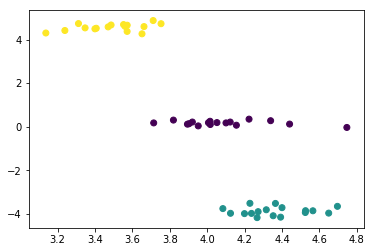

In [5]:
X, y = make_blobs(n_samples=50, centers=3, cluster_std=0.2, center_box=(-5, 5))
show2dfig(X, y)

# 训练

可以看到训练过程，红点为滑动窗格的中心

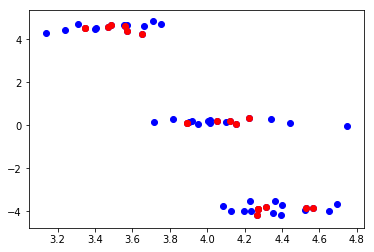

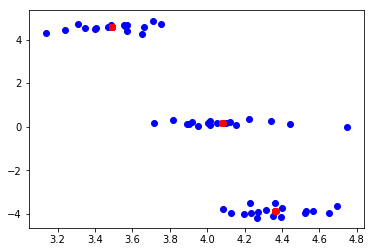

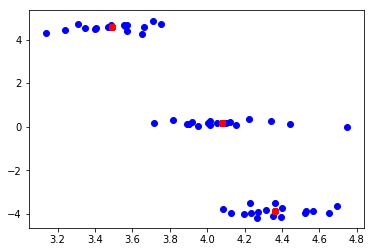

In [6]:
estimator = MeanShift(n_clusters=3, n_windows=20, epsilon=1.0, sigma=2, thresh=0.1, min_move=1e-3)
centroids = estimator.fit(X)
y_pred = estimator.predict(X)

# 显示最终结果

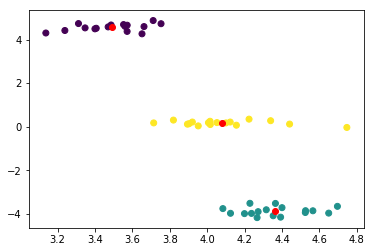

In [7]:
# 作图显示
plt.figure('result')
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(centroids[:, 0], centroids[:, 1], c='r')
plt.show()